## Graf approach - Fashion Compatibility Challenge

#### Librerías necesarias:

In [19]:
import pandas as pd
from itertools import combinations
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from torch_geometric.data import Data
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import train_test_split_edges


#### Preprocesado:

In [20]:
outfit = pd.read_csv('outfit_preprocessed.csv')
product = pd.read_csv('product_preprocessed.csv')

In [21]:
encoded_images = np.load('encoded_images.npy')
flat_encoded_imgs = tf.reshape(encoded_images, [tf.shape(encoded_images)[0], -1])
normalized_imgs = tf.nn.l2_normalize(flat_encoded_imgs, axis=1)
new_columns_df = pd.DataFrame(normalized_imgs)


new_columns_df = pd.DataFrame(normalized_imgs)

assert len(new_columns_df) == len(product), "El número de filas no coincide entre el tensor y el DataFrame 'product'."

product = pd.concat([product, new_columns_df], axis=1, ignore_index=False)

new_column_names = [f'feature_{i}' for i in range(normalized_imgs.shape[1])]
product[new_column_names] = new_columns_df

C:\Users\joans\AppData\Local\Temp\ipykernel_16248\3891781217.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  product[new_column_names] = new_columns_df
C:\Users\joans\AppData\Local\Temp\ipykernel_16248\3891781217.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  product[new_column_names] = new_columns_df
C:\Users\joans\AppData\Local\Temp\ipykernel_16248\3891781217.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

In [22]:
pairs = outfit.groupby('cod_outfit')['cod_modelo_color'].apply(lambda x: list(combinations(sorted(x), 2)))

flat_pairs = [pair for sublist in pairs for pair in sublist]

pair_df = pd.DataFrame(flat_pairs, columns=['producto1', 'producto2'])
edges_with_weights = pair_df.groupby(['producto1', 'producto2']).size().reset_index(name='weight')

edges_with_weights

,producto1,producto2,weight
0,37000577-10,47004377-01,1
1,37000577-10,47032878-99,1
2,37000577-10,47087124-DC,1
3,37000577-10,57003777-02,1
4,37000577-10,57004052-PL,1
...,...,...,...
70254,67070592-08,67090516-99,1
70255,67071502-TM,67080595-30,1
70256,67071502-TM,67090611-30,1
70257,67080516-17,67090509-09,1


In [23]:
# Define la función
def custom_function(x):
    return np.exp(0.2 * (x - 2))

# Suponiendo que tienes un DataFrame llamado 'df' y una columna 'weights'
# Aplica la función a la columna usando apply()
edges_with_weights['weight'] = edges_with_weights['weight'].apply(custom_function)


In [24]:
product_to_index = {id_producto: idx for idx, id_producto in (enumerate(product['cod_modelo_color'].unique()))}

edges_index = torch.tensor([(product_to_index[id1], product_to_index[id2]) for id1, id2 in edges_with_weights[['producto1', 'producto2']].values], dtype=torch.long).t().contiguous()

edges_weight = torch.tensor(edges_with_weights['weight'].values, dtype=torch.float)

product.drop(columns = ['cod_modelo_color', 'des_filename'], inplace = True)

node_features = torch.tensor(product.iloc[:, 1:].values, dtype=torch.float)

data = Data(x=node_features, edge_index=edges_index, edge_attr=edges_weight)


In [25]:
index_to_product = {idx: product_id for product_id, idx in product_to_index.items()}


#### Entrenamiento del modelo:

In [27]:
data = train_test_split_edges(data)


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 32)
        self.conv2 = GCNConv(32, 16)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)

        return x

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def get_link_score(edge_index, node_embeddings):
    start_embeddings = node_embeddings[edge_index[0]]
    end_embeddings = node_embeddings[edge_index[1]]
    scores = torch.sum(start_embeddings * end_embeddings, dim=1)
    probabilities = torch.sigmoid(scores)
    return probabilities

# Función de entrenamiento
def train():
    model.train()
    optimizer.zero_grad()
    
    edge_index = data.train_pos_edge_index
    if edge_index.size(0) != 2:
        edge_index = edge_index.t().contiguous()
    edge_index = edge_index.to(torch.long)

    data.edge_index = edge_index
    node_embeddings = model(data.x, data.edge_index)

    pos_edge_scores = get_link_score(data.edge_index, node_embeddings)

    neg_edge_index = negative_sampling(edge_index=data.edge_index, num_nodes=data.num_nodes, num_neg_samples=data.edge_index.size(1))
    neg_edge_scores = get_link_score(neg_edge_index, node_embeddings)

    loss = torch.nn.functional.binary_cross_entropy(torch.cat([pos_edge_scores, neg_edge_scores]), torch.cat([torch.ones(pos_edge_scores.size(0)), torch.zeros(neg_edge_scores.size(0))]))
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    with torch.no_grad():
        node_embeddings = model(data.x, data.train_pos_edge_index)

        pos_edge_scores = get_link_score(data.test_pos_edge_index, node_embeddings)
        neg_edge_scores = get_link_score(data.test_neg_edge_index, node_embeddings)

        true_labels = torch.cat([torch.ones(data.test_pos_edge_index.size(1)), torch.zeros(data.test_neg_edge_index.size(1))])
        pred_scores = torch.cat([pos_edge_scores, neg_edge_scores])

        auc_score = roc_auc_score(true_labels.cpu(), pred_scores.cpu())
        return auc_score


train_losses = []
val_aucs = []

def validate():
    model.eval()
    with torch.no_grad():
        node_embeddings = model(data.x, data.val_pos_edge_index)
        pos_edge_scores = get_link_score(data.val_pos_edge_index, node_embeddings)
        neg_edge_scores = get_link_score(data.val_neg_edge_index, node_embeddings)
        
        true_labels = torch.cat([torch.ones(data.val_pos_edge_index.size(1)), torch.zeros(data.val_neg_edge_index.size(1))])
        pred_scores = torch.cat([pos_edge_scores, neg_edge_scores])
        auc_score = roc_auc_score(true_labels.cpu(), pred_scores.cpu())
        return auc_score
    

for epoch in range(500):
    loss = train()
    train_losses.append(loss.item())
    
    val_auc = validate()
    val_aucs.append(val_auc)
    
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}, Val AUC: {val_auc}')



c:\Python3\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 1, Loss: 45.59999465942383, Val AUC: 0.6097105800958922
Epoch: 2, Loss: 45.426578521728516, Val AUC: 0.6119452633931748
Epoch: 3, Loss: 45.47709655761719, Val AUC: 0.6130673810266363
Epoch: 4, Loss: 45.19590377807617, Val AUC: 0.6145245339952212
Epoch: 5, Loss: 45.11578369140625, Val AUC: 0.6224557731865705
Epoch: 6, Loss: 44.67730712890625, Val AUC: 0.6268881258987807
Epoch: 7, Loss: 44.39573287963867, Val AUC: 0.630427130650408
Epoch: 8, Loss: 43.84196853637695, Val AUC: 0.6350206728502934
Epoch: 9, Loss: 43.09093475341797, Val AUC: 0.638248760990138
Epoch: 10, Loss: 42.29557800292969, Val AUC: 0.6509679249635474
Epoch: 11, Loss: 41.12598419189453, Val AUC: 0.6745321564669939
Epoch: 12, Loss: 39.658626556396484, Val AUC: 0.6945308765030621
Epoch: 13, Loss: 37.829322814941406, Val AUC: 0.7070446731292108
Epoch: 14, Loss: 36.231624603271484, Val AUC: 0.712409059279046
Epoch: 15, Loss: 34.28330612182617, Val AUC: 0.7153935721930702
Epoch: 16, Loss: 32.40684127807617, Val AUC: 0.7

#### Resultados:

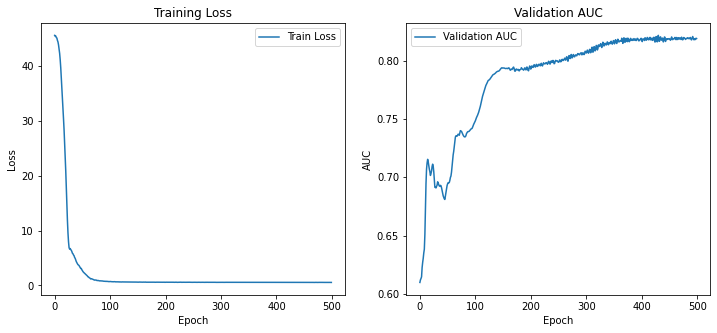

Test AUC: 0.8167512533378165
ID 1: 57077734-99, ID 2: 57086003-PL, Score: 0.9245
ID 1: 47032878-99, ID 2: 57094007-78, Score: 0.9759
ID 1: 57004410-99, ID 2: 57006017-OR, Score: 0.8880
ID 1: 53003753-CU, ID 2: 53015744-05, Score: 0.8237
ID 1: 57022513-30, ID 2: 57030776-99, Score: 0.7548
ID 1: 47095840-02, ID 2: 57010456-40, Score: 0.9961
ID 1: 43013764-99, ID 2: 53060592-02, Score: 1.0000
ID 1: 47065143-99, ID 2: 57002533-PL, Score: 0.7949
ID 1: 53093047-99, ID 2: 67010057-PL, Score: 0.8175
ID 1: 43005827-05, ID 2: 43077762-01, Score: 0.9976
ID 1: 57006709-06, ID 2: 57007884-99, Score: 0.8429
ID 1: 57055921-02, ID 2: 57065783-85, Score: 0.9432
ID 1: 67040094-99, ID 2: 67050573-99, Score: 0.7900
ID 1: 53070567-02, ID 2: 53090827-OR, Score: 0.8657
ID 1: 53025032-05, ID 2: 53035745-43, Score: 0.9491
ID 1: 57040274-OR, ID 2: 57040292-TC, Score: 1.0000
ID 1: 57004052-PL, ID 2: 57040365-99, Score: 0.5252
ID 1: 53053772-02, ID 2: 53080920-99, Score: 0.9348
ID 1: 53030963-99, ID 2: 53060830-O

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_aucs, label='Validation AUC')
plt.title('Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.show()

# Evaluar el modelo en el conjunto de prueba
test_auc = test()
print(f'Test AUC: {test_auc}')

threshold = 0.5


model.eval()
with torch.no_grad():
    node_embeddings = model(data.x, torch.cat([data.test_pos_edge_index, data.test_neg_edge_index], dim=-1))
    pos_edge_scores = get_link_score(data.test_pos_edge_index, node_embeddings)
    neg_edge_scores = get_link_score(data.test_neg_edge_index, node_embeddings)
    all_scores = torch.cat([pos_edge_scores, neg_edge_scores], dim=0)

predicted_edge_indices = (all_scores > threshold).nonzero(as_tuple=True)[0]
predicted_edges = torch.cat([data.test_pos_edge_index, data.test_neg_edge_index], dim=-1)[:, predicted_edge_indices]
predicted_scores = all_scores[predicted_edge_indices]

predicted_edges_ids_scores = [(index_to_product[predicted_edges[0, i].item()], index_to_product[predicted_edges[1, i].item()], predicted_scores[i].item()) for i in range(predicted_edges.size(1))]

for edge1, edge2, score in predicted_edges_ids_scores:
    print(f"ID 1: {edge1}, ID 2: {edge2}, Score: {score:.4f}")

In [115]:
predicted_edges_ids = [(index_to_product[start_idx.item()], index_to_product[end_idx.item()]) for start_idx, end_idx in predicted_edges.t()]

for edge in predicted_edges_ids:
    print(edge)

('57024032-OR', '57076026-05')
('57000438-OR', '57040454-81')
('53010582-TM', '53020607-07')
('57012518-99', '57030776-99')
('53040541-TN', '57064001-TM')
('57014036-PL', '57025798-05')
('57005977-TO', '57025801-05')
('57020363-OR', '57050185-TC')
('57034768-TM', '57094432-30')
('57013807-99', '57066004-99')
('57027717-OR', '57094032-CU')
('57037735-95', '57067755-99')
('57000440-52', '57040357-43')
('57040376-OR', '57040579-32')
('43033720-52', '43087018-BL')
('51080862-99', '53015757-05')
('47005935-99', '57040037-99')
('53030720-OR', '53080805-92')
('57007743-99', '57023805-99')
('53033037-02', '53040593-08')
('57003777-99', '57040598-99')
('47003773-01', '57040317-20')
('53023736-07', '53043747-99')
('67040169-09', '67071502-TM')
('57010275-OR', '57046024-99')
('57086313-95', '57096020-99')
('47005944-32', '57050271-OR')
('57044395-09', '57095798-35')
('43003763-OR', '43073737-OR')
('57040274-OR', '57050302-07')
('57026007-OR', '57040278-99')
('57063803-02', '57083794-05')
('530505

## Outfit Generation

In [64]:
product = pd.read_csv('./datathon/dataset/product_preprocessed_3.csv')


In [61]:
data.test_neg_edge_index

tensor([[2458,  102, 3886,  ..., 2249, 5618,  308],
        [5828, 3404, 7819,  ..., 7658, 5822, 4938]])

In [100]:
np.argmax(pd.Series(pos_edge_scores))

15

In [101]:
relation = (index_to_product[data.test_pos_edge_index[0][15].item()], index_to_product[data.test_pos_edge_index[1][15].item()])

In [102]:
relation

('57040326-52', '57050043-PL')

In [104]:
product[product['cod_modelo_color'] == '57050043-PL']

,cod_modelo_color,des_filename,R,G,B,des_fabric_C-COMPLEMENTOS,des_fabric_J-JEANS,des_fabric_K-CIRCULAR,des_fabric_L-PIEL,des_fabric_O-POLIPIEL,...,des_product_family_Shorts,des_product_family_Skirts,des_product_family_Sweater,des_product_family_Sweatshirts,des_product_family_T-shirt,des_product_family_Tops,des_product_family_Trenchcoats,des_product_family_Trousers,des_product_family_Vest,des_product_family_Wallets & cases
3900,57050043-PL,datathon/images/2023_57050043_PL.jpg,192,192,192,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
product_to_index['57050184-01']

8923

In [114]:
indices = (data.test_pos_edge_index == 8923).any(dim=0)

# Reducción de b para mantener solo los elementos en los índices encontrados
b_reduced = pos_edge_scores[indices]

# Reducción de a para mantener solo las columnas donde aparece 6162
a_reduced = data.test_pos_edge_index[:, indices]

In [115]:
a_reduced

tensor([[5107,  478, 6455,  149, 5364],
        [8923, 8923, 8923, 8923, 8923]])

In [120]:
b_reduced

tensor([0.9838, 0.9987, 0.8453, 0.2119, 0.9701])

In [122]:
index_to_product[5364]

'57010275-OR'

In [112]:
product[product['cod_modelo_color'] == '57050184-01']

,cod_modelo_color,des_filename,R,G,B,des_fabric_C-COMPLEMENTOS,des_fabric_J-JEANS,des_fabric_K-CIRCULAR,des_fabric_L-PIEL,des_fabric_O-POLIPIEL,...,des_product_family_Shorts,des_product_family_Skirts,des_product_family_Sweater,des_product_family_Sweatshirts,des_product_family_T-shirt,des_product_family_Tops,des_product_family_Trenchcoats,des_product_family_Trousers,des_product_family_Vest,des_product_family_Wallets & cases
8923,57050184-01,datathon/images/2023_57050184_01.jpg,255,255,255,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model Aresta

Currently not working, but future implementation

In [93]:
class EdgePredictionModel(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super(EdgePredictionModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        # Salida para clasificación de aristas
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16 * 2, 1),
            torch.nn.Sigmoid(),
        )
        # Salida para regresión de pesos de aristas
        self.regressor = torch.nn.Linear(16 * 2, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        
        # Para cada arista, concatenamos las incrustaciones de los nodos de inicio y fin
        start_embeddings = x[edge_index[0]]
        end_embeddings = x[edge_index[1]]
        edge_embeddings = torch.cat((start_embeddings, end_embeddings), dim=1)
        
        # Clasificación de la existencia de la arista
        edge_class = self.classifier(edge_embeddings)
        # Regresión del peso de la arista
        edge_weight = self.regressor(edge_embeddings)

        return edge_class, edge_weight


In [94]:
def train():
    model.train()
    optimizer.zero_grad()

    # Obtenemos las predicciones
    edge_class, edge_weight = model(data.x, data.train_pos_edge_index)

    # Preparamos las etiquetas verdaderas para la existencia de aristas
    pos_edge_labels = torch.ones(data.train_pos_edge_index.size(1))
    neg_edge_labels = torch.zeros(data.train_neg_edge_index.size(1))
    all_edge_labels = torch.cat([pos_edge_labels, neg_edge_labels], dim=0)

    # Calculamos la pérdida para la clasificación de la existencia de aristas
    loss_class = F.binary_cross_entropy(edge_class, all_edge_labels)

    # Preparamos las etiquetas verdaderas para los pesos de las aristas
    # Suponiendo que 'data.edge_attr' contiene los pesos reales de las aristas
    edge_weights = torch.cat([data.edge_attr[data.train_pos_edge_index], torch.zeros_like(data.edge_attr[data.train_neg_edge_index])], dim=0)

    # Calculamos la pérdida para la regresión de los pesos de las aristas
    # Solo consideramos los pesos de las aristas positivas para la regresión
    loss_weight = F.mse_loss(edge_weight[data.train_pos_edge_index], edge_weights[data.train_pos_edge_index])

    # Combinamos las pérdidas y realizamos el backpropagation
    loss = loss_class + loss_weight
    loss.backward()
    optimizer.step()

    return loss.item()

def evaluate(edge_index):
    model.eval()
    with torch.no_grad():
        edge_class, edge_weight = model(data.x, edge_index)
        return edge_class, edge_weight

# Inicializar el modelo y el optimizador
model = EdgePredictionModel(num_node_features=data.num_node_features, num_edge_features=data.num_edge_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [95]:
# Usar el conjunto de prueba para evaluar el modelo
edge_class_test, edge_weight_test = evaluate(data.test_pos_edge_index)

# Convertir las probabilidades de clasificación en predicciones binarias usando un umbral
edge_existence_pred = (edge_class_test > 0.5).float()

# Consideramos los pesos predichos solo para las aristas que se predijeron como existentes
predicted_edge_weights = edge_weight_test[edge_existence_pred.bool()]


In [99]:
# Supongamos que ya hemos evaluado el modelo como se mostró antes
edge_class_test, edge_weight_test = evaluate(data.test_pos_edge_index)

# Convertir las probabilidades de clasificación en predicciones binarias usando un umbral
threshold = 0.5
edge_existence_pred = (edge_class_test > threshold).squeeze()

# Filtrar las aristas que se predijeron como existentes
predicted_existence = data.test_pos_edge_index[:, edge_existence_pred]

# Obtener los pesos predichos para las aristas existentes
predicted_weights = edge_weight_test[edge_existence_pred].squeeze()

# Mapear los índices de los nodos a identificadores de productos
predicted_edges_ids = [(index_to_product[start.item()], index_to_product[end.item()]) for start, end in predicted_existence.t()]

# Imprimir las aristas con sus pesos predichos
for edge, weight in zip(predicted_edges_ids, predicted_weights):
    print(f"Arista1: {edge[0]}, Arista2: {edge[1]}, Peso_predicho: {weight:.4f}")

Arista1: 57047717-99, Arista2: 57097716-99, Peso_predicho: -0.2039
Arista1: 53003752-99, Arista2: 57064001-37, Peso_predicho: 1.8426
Arista1: 53020726-99, Arista2: 53085759-01, Peso_predicho: -3.2984
Arista1: 57010043-57, Arista2: 57030040-57, Peso_predicho: -5.8844
Arista1: 57004789-99, Arista2: 57006000-65, Peso_predicho: -1.7313
Arista1: 47005582-99, Arista2: 57042885-99, Peso_predicho: -0.1812
Arista1: 51050835-74, Arista2: 53070616-07, Peso_predicho: -7.1992
Arista1: 53055031-99, Arista2: 57084378-99, Peso_predicho: -0.1243
Arista1: 57040161-TC, Arista2: 57093253-01, Peso_predicho: -5.8244
Arista1: 57065806-52, Arista2: 57094427-02, Peso_predicho: -15.9700
Arista1: 53090733-99, Arista2: 57047657-56, Peso_predicho: -2.3288
Arista1: 53073765-99, Arista2: 57067893-CU, Peso_predicho: 0.3191
Arista1: 57002886-88, Arista2: 57010006-99, Peso_predicho: -5.6606
Arista1: 57010731-99, Arista2: 57040729-99, Peso_predicho: -0.1210
Arista1: 57003822-34, Arista2: 57033802-99, Peso_predicho: -9.0